# Imports

In [1]:
import datetime
import glob
import itertools
import json
import os
import pickle
import random
import re
from string import punctuation

In [2]:
import statistics

import fuzzywuzzy
import geopandas as gpd
import humanize
import missingno as msno
import numpy as np
import pandas as pd
import recordlinkage
import scipy as sp
import statsmodels.formula.api as smf
from pandas_profiling import ProfileReport

In [3]:
SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 18
MAPBOX_STYLE = "dark"
MAPBOX_HEIGHT = 800
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
import matplotlib.font_manager
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from matplotlib.ticker import PercentFormatter
px.set_mapbox_access_token(os.getenv("MAPBOX_TOKEN"))
matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext="ttf")
plt.style.use("seaborn-colorblind")
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "Open Sans"
plt.rcParams["figure.figsize"] = 15, 6
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [38]:
from mlxtend.plotting import plot_decision_regions
from sklearn import __version__ as sklearn_version
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF, PCA
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import (accuracy_score, average_precision_score, classification_report,
                             confusion_matrix, mean_absolute_error,
                             mean_squared_error, plot_precision_recall_curve,
                             precision_recall_curve, r2_score, roc_auc_score,
                             roc_curve)
from sklearn.model_selection import (GridSearchCV, KFold, cross_val_score,
                                     cross_validate, learning_curve,
                                     train_test_split)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (LabelEncoder, MaxAbsScaler, MinMaxScaler, Normalizer,
                                   StandardScaler, normalize, scale)
from sklearn.tree import DecisionTreeClassifier

# Functions

In [42]:
def plot_labeled_decision_regions(X, y, models):
    '''
    Function producing a scatter plot of the instances contained 
    in the 2D dataset (X,y) along with the decision 
    regions of two trained classification models contained in the
    list 'models'.
            
    Parameters
    ----------
    X: pandas DataFrame corresponding to two numerical features 
    y: pandas Series corresponding the class labels
    models: list containing two trained classifiers 
    
    '''
    if len(models) != 2:
        raise Exception('''
        Models should be a list containing only two trained classifiers.
        ''')
    if not isinstance(X, pd.DataFrame):
        raise Exception('''
        X has to be a pandas DataFrame with two numerical features.
        ''')
    if not isinstance(y, pd.Series):
        raise Exception('''
        y has to be a pandas Series corresponding to the labels.
        ''')
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True)
    for i, model in enumerate(models):
        plot_decision_regions(X.values, y.values, model, legend=2, ax=ax[i])
        ax[i].set_title(model.__class__.__name__)
        ax[i].set_xlabel(X.columns[0])
        if i == 0:
            ax[i].set_ylabel(X.columns[1])
        ax[i].set_ylim(X.values[:, 1].min(), X.values[:, 1].max())
        ax[i].set_xlim(X.values[:, 0].min(), X.values[:, 0].max())
    plt.tight_layout()
    plt.show()

# Wisconsin Breast Cancer

## Data

In [32]:
df = pd.read_csv('datasets/wbc.csv')
df.sample(10)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
418,906024,B,12.700,12.17,80.88,495.0,0.08785,0.05794,0.02360,0.02402,...,16.92,88.12,566.9,0.1314,0.1607,0.09385,0.08224,0.2775,0.09464,NaN
11,84610002,M,15.780,17.89,103.60,781.0,0.09710,0.12920,0.09954,0.06606,...,27.28,136.50,1299.0,0.1396,0.5609,0.39650,0.18100,0.3792,0.10480,NaN
121,86517,M,18.660,17.12,121.40,1077.0,0.10540,0.11000,0.14570,0.08665,...,24.90,145.40,1549.0,0.1503,0.2291,0.32720,0.16740,0.2894,0.08456,NaN
367,9011495,B,12.210,18.02,78.31,458.4,0.09231,0.07175,0.04392,0.02027,...,24.04,93.85,624.6,0.1368,0.2170,0.24130,0.08829,0.3218,0.07470,NaN
341,898143,B,9.606,16.84,61.64,280.5,0.08481,0.09228,0.08422,0.02292,...,23.07,71.25,353.6,0.1233,0.3416,0.43410,0.08120,0.2982,0.09825,NaN
187,874373,B,11.710,17.19,74.68,420.3,0.09774,0.06141,0.03809,0.03239,...,21.39,84.42,521.5,0.1323,0.1040,0.15210,0.10990,0.2572,0.07097,NaN
21,8510824,B,9.504,12.44,60.34,273.9,0.10240,0.06492,0.02956,0.02076,...,15.66,65.13,314.9,0.1324,0.1148,0.08867,0.06227,0.2450,0.07773,NaN
135,868202,M,12.770,22.47,81.72,506.3,0.09055,0.05761,0.04711,0.02704,...,33.37,92.04,653.6,0.1419,0.1523,0.21770,0.09331,0.2829,0.08067,NaN
468,9113538,M,17.600,23.33,119.00,980.5,0.09289,0.20040,0.21360,0.10020,...,28.87,143.60,1437.0,0.1207,0.4785,0.51650,0.19960,0.2301,0.12240,NaN
72,859717,M,17.200,24.52,114.20,929.4,0.10710,0.18300,0.16920,0.07944,...,33.82,151.60,1681.0,0.1585,0.7394,0.65660,0.18990,0.3313,0.13390,NaN


In [33]:
df.diagnosis = df.diagnosis.astype('category').cat.codes

In [34]:
target = "diagnosis"
y = df[target]
X = df.drop(target, axis=1)[["radius_mean", "concave points_mean"]]#.to_numpy()

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

## Decision Tree

In [57]:
# Instantiate a DecisionTreeClassifier 'dt' with a maximum depth of 6
dt = DecisionTreeClassifier(max_depth=6, random_state=1)

# Setup the hyperparameter grid
param_grid = {"criterion": ["gini", "entropy"]}

# Instantiate the GridSearchCV object: logreg_cv
dt_cv = GridSearchCV(dt, param_grid, n_jobs=-1)

# Fit it to the data
dt_cv.fit(X_train, y_train)

# Print the tuned parameters and score
print(f"CV tuned params: {dt_cv.best_params_}")
print(f"CV best accuracy: {dt_cv.best_score_}")

# Predict test set labels
y_pred = dt_cv.predict(X_test)
print(f"Sample predictions: {y_pred[0:5]}")

# Compute test set accuracy  
acc = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {acc}")

CV tuned params: {'criterion': 'entropy'}
CV best accuracy: 0.8967032967032967
Sample predictions: [1 0 0 1 0]
Test set accuracy: 0.8947368421052632


## Logistic Regression

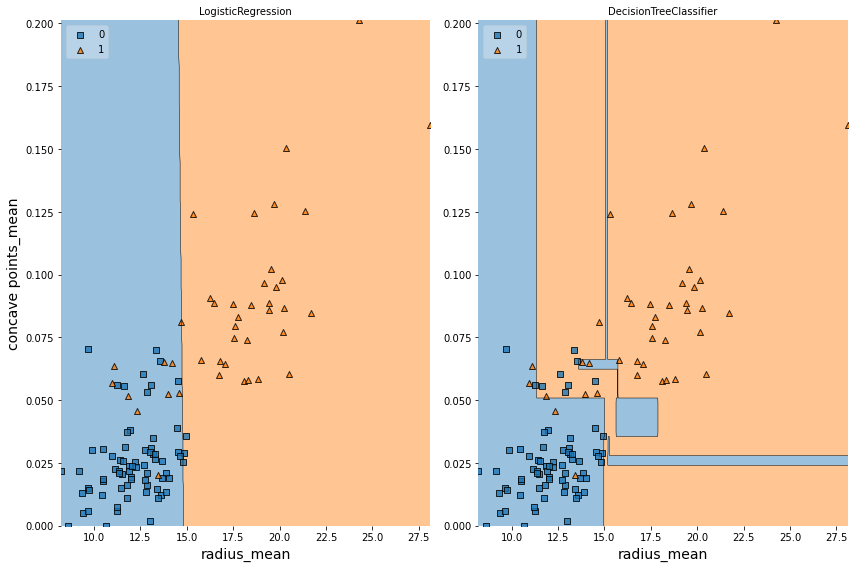

In [43]:
# Instatiate logreg
logreg = LogisticRegression(random_state=1)

# Fit logreg to the training set
logreg.fit(X_train, y_train)

# Define a list called clfs containing the two classifiers logreg and dt
clfs = [logreg, dt]

# Review the decision regions of the two classifiers
plot_labeled_decision_regions(X_test, y_test, clfs)